## Recognizing handwritten digits using a convolutional network

### Loading the data

First we load the required packages:

In [25]:
using Flux, Flux.Data.MNIST, Images, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Printf, BSON

Now we read in the data:

In [2]:
labels = MNIST.labels();
images = MNIST.images();

In [3]:
length(labels)

60000

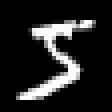

In [39]:
display(images[1])

In [35]:
size(images[1])

(28, 28)

In [40]:
labels[1]

5

In [6]:
# Bundle images together with labels and group into minibatchess
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = Float32.(X[idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end

make_minibatch (generic function with 1 method)

In [12]:
batch_size = 128
mb_idxs = partition(1:length(images), batch_size)
train_set = [make_minibatch(images, labels, i) for i in mb_idxs];

In [15]:
# Prepare test set as one giant minibatch:
test_images = MNIST.images(:test)
test_labels = MNIST.labels(:test)
test_set = make_minibatch(test_images, test_labels, 1:length(test_images));

### Setting up a convolutional neural network model

In [32]:
?Conv

search: Conv convert convexhull DepthwiseConv code_native @code_native conj



```
Conv(size, in=>out)
Conv(size, in=>out, relu)
```

Standard convolutional layer. `size` should be a tuple like `(2, 2)`. `in` and `out` specify the number of input and output channels respectively.

Data should be stored in WHCN order. In other words, a 100×100 RGB image would be a `100×100×3×1` array, and a batch of 50 would be a `100×100×3×50` array.

Takes the keyword arguments `pad`, `stride` and `dilation`.


In [16]:
# Define our model.  
# We will use a simple convolutional architecture with
# three iterations of Conv -> ReLU -> MaxPool, 
# followed by a final Dense layer that
# feeds into a softmax probability output.
@info("Constructing model...")
model = Chain(
    # First convolution, operating upon a 28x28 image
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    x -> maxpool(x, (2,2)),

    # Second convolution, operating upon a 14x14 image
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    x -> maxpool(x, (2,2)),

    # Third convolution, operating upon a 7x7 image
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    x -> maxpool(x, (2,2)),

    # Reshape 3d tensor into a 2d one, 
    # at this point it should be (3, 3, 32, N)
    # which is where we get the 288 in the `Dense` 
    # layer below:
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 10),

    # Finally, softmax to get nice probabilities
    softmax,
)

┌ Info: Constructing model...
└ @ Main In[16]:4


Chain(Conv((3, 3), 1=>16, NNlib.relu), getfield(Main, Symbol("##9#13"))(), Conv((3, 3), 16=>32, NNlib.relu), getfield(Main, Symbol("##10#14"))(), Conv((3, 3), 32=>32, NNlib.relu), getfield(Main, Symbol("##11#15"))(), getfield(Main, Symbol("##12#16"))(), Dense(288, 10), NNlib.softmax)

In [17]:
# Make sure our model is nicely precompiled 
# before starting our training loop
model(train_set[1][1])

Tracked 10×128 Array{Float32,2}:
 0.00180607  0.000692555  0.00112681  0.00143349  …  0.000432991  0.000174138
 0.0114105   0.00338544   0.0116013   0.00103415     0.0154825    0.00153919 
 0.0005193   0.00159591   0.00187203  0.0041794      0.000604512  0.000589073
 0.199137    0.233878     0.11968     0.0945053      0.125249     0.131407   
 0.0221129   0.112573     0.0940939   0.0164832      0.0229341    0.0114338  
 0.0900496   0.114881     0.0957023   0.0272095   …  0.0401364    0.0588964  
 0.0176924   0.00390941   0.0110788   0.00510167     0.0124916    0.000720865
 0.325168    0.346883     0.249772    0.54771        0.442028     0.521354   
 0.160219    0.00885474   0.036308    0.00529267     0.0256448    0.00922572 
 0.171885    0.173348     0.378765    0.297051       0.314997     0.26466    

In [37]:
# `loss()` calculates the crossentropy loss 
# between our prediction `y_hat`
# (calculated from `model(x)`) and 
# the ground truth `y`.  
# We augment the data a bit, 
# adding gaussian random noise to our image 
# to make it more robust.
function loss(x, y)
    # We augment `x` a little bit here, 
    # adding in random noise
    x_aug = x .+ 0.1*gpu(randn(eltype(x), size(x)))

    y_hat = model(x_aug)
    return crossentropy(y_hat, y)
end

loss (generic function with 1 method)

In [38]:
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

accuracy (generic function with 1 method)

In [27]:
# Train our model with the given training set 
# using the ADAM optimizer and
# printing out performance against 
# the test set as we go.
opt = ADAM(0.001)

@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch_idx in 1:100
    global best_acc, last_improvement
    # Train for a single epoch
    Flux.train!(loss, params(model), train_set, opt)

    # Calculate accuracy:
    acc = accuracy(test_set...)
    @info(@sprintf("[%d]: Test accuracy: %.4f", 
            epoch_idx, acc))
    
    # If our accuracy is good enough, quit out.
    if acc >= 0.999
        @info(" -> Early-exiting: We reached our target accuracy of 99.9%")
        break
    end

    # If this is the best accuracy we've seen so far, 
    # save the model using the BSON package
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to mnist_conv.bson")
        BSON.@save "mnist_conv.bson" model epoch_idx acc
        best_acc = acc
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, 
    # drop our learning rate:
    if epoch_idx - last_improvement >= 5 && opt.eta > 1e-6
        opt.eta /= 10.0
        @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")

        # After dropping learning rate, 
        # give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main In[27]:5
┌ Info: [1]: Test accuracy: 0.9791
└ @ Main In[27]:15
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[27]:25
┌ Info: [2]: Test accuracy: 0.9834
└ @ Main In[27]:15
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[27]:25
┌ Info: [3]: Test accuracy: 0.9860
└ @ Main In[27]:15
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[27]:25
┌ Info: [4]: Test accuracy: 0.9849
└ @ Main In[27]:15
┌ Info: [5]: Test accuracy: 0.9873
└ @ Main In[27]:15
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[27]:25
┌ Info: [6]: Test accuracy: 0.9878
└ @ Main In[27]:15
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[27]:25
┌ Info: [7]: Test accuracy: 0.9879
└ @ Main In[27]:15
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[27]:25
┌ Info: [8]: Test accuracy: 0.9885
└ @ Main In[27]:15